# All figures used in Privugger-AG
## Imports

In [43]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import pymc3 as pm
import numpy as np
from GPyOpt.methods import BayesianOptimization
import arviz as az
import theano
import theano.tensor as tt
import pandas as pd
import opendp.smartnoise.core as sn
from scipy import optimize
#import pybobyqa
#from ax import optimize as facebookOpt
from scipy import stats as st
from skopt.learning import ExtraTreesRegressor
from skopt import Optimizer
from skopt.plots import plot_gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import seaborn as sns

In [ ]:
plt.style.use('seaborn-darkgrid')

# Curvature of Average Age mutual information
    - Under the assumption that all distributions are normal distributions

Text(0.5, 1.0, 'Leakage of average age depending on standard deviation of $n$')

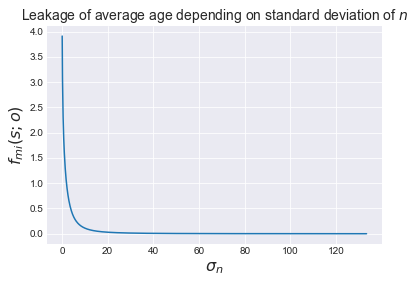

In [2]:
def test(X):
    res = (np.log(15*15+9*X**2)-np.log(9*X**2))/2
    return res

x = np.linspace(0.1,1/12*(40)**2, 1000)
y = [test(xi) for xi in x]
plt.plot(x,y)
plt.ylabel(r"$f_{mi}(s;o)$", fontdict={"fontsize": 16})
plt.xlabel(r"$\sigma_n$", fontdict={"fontsize": 16})
plt.title("Leakage of average age depending on standard deviation of $n$", fontdict={"fontsize": 14})

In [3]:
max(y)

3.9122229654388097

# Identifying Alice (Main idea)

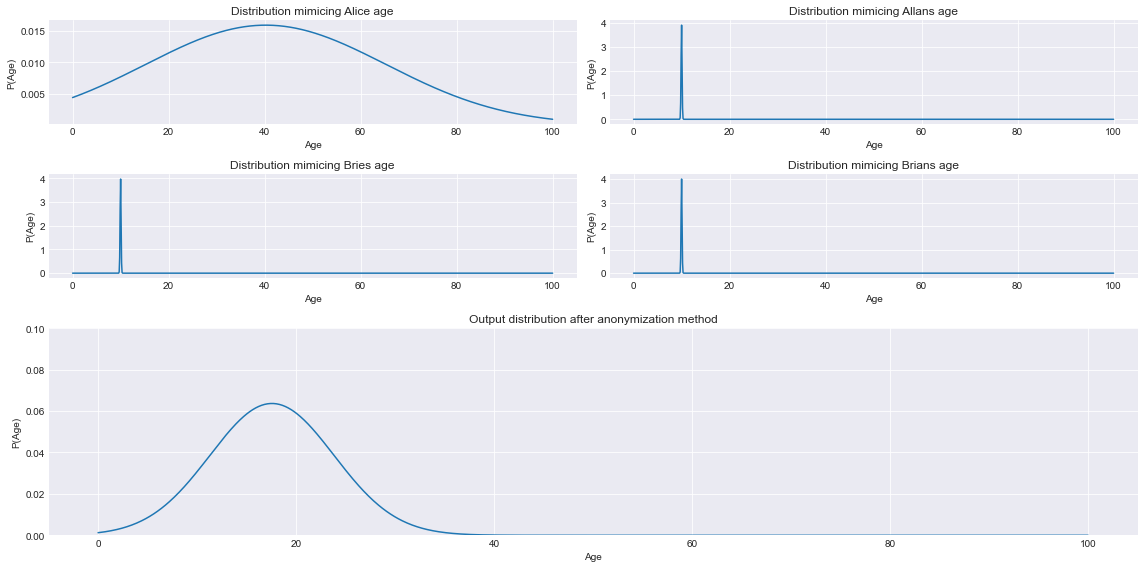

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats as st
import numpy as np

x = np.linspace(0,100,1000)
y1 = st.norm(40,25).rvs(10000)
y2 = st.norm(10,0.1).rvs(10000)
y3 = st.norm(10,0.1).rvs(10000)
y4 = st.norm(10,0.1).rvs(10000)
out = (y1+y2+y3+y4)/4

fig = plt.figure(figsize=(16,8))
gs = gridspec.GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 2])

ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(x, st.norm.pdf(x, np.mean(y1), np.std(y1)), label="Alice")
ax0.set_title("Distribution mimicing Alice age")
ax0.set_xlabel("Age")
ax0.set_ylabel("P(Age)")


ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(x, st.norm.pdf(x, np.mean(y2), np.std(y2)), label="Allen")
ax1.set_title("Distribution mimicing Allans age")
ax1.set_xlabel("Age")
ax1.set_ylabel("P(Age)")


ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(x, st.norm.pdf(x, np.mean(y3), np.std(y3)),label="Brie" )
ax2.set_title("Distribution mimicing Bries age")
ax2.set_xlabel("Age")
ax2.set_ylabel("P(Age)")


ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(x, st.norm.pdf(x, np.mean(y4), np.std(y4)),label="Brian")
ax3.set_title("Distribution mimicing Brians age")
ax3.set_xlabel("Age")
ax3.set_ylabel("P(Age)")


ax4 = fig.add_subplot(gs[2:, :])
ax4.plot(x, st.norm.pdf(x, np.mean(out), np.std(out)), label="Output")
ax4.set_ylim(0,0.1)
ax4.set_title("Output distribution after anonymization method")
ax4.set_xlabel("Age")
ax4.set_ylabel("P(Age)")

plt.tight_layout()

### Rework

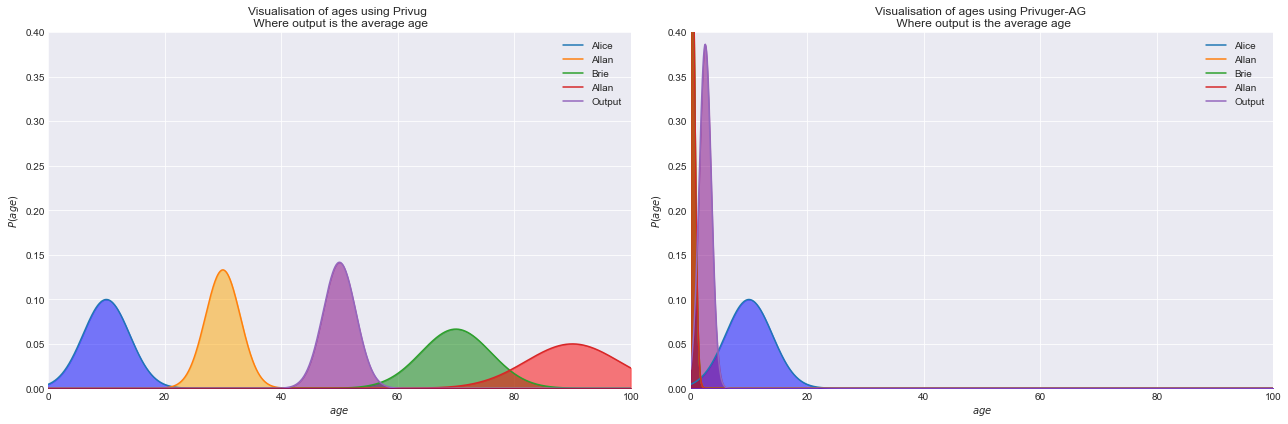

In [6]:
x = np.linspace(0,100,1000)
def Privug():
    y1 = st.norm(10,4)
    y2 = st.norm(30,3)
    y3 = st.norm(70,6)
    y4 = st.norm(90,8)
    o = (y1.rvs(10_000)+y2.rvs(10_000)+y3.rvs(10_000)+y4.rvs(10_000))/4
    out = st.norm(np.mean(o), np.std(o))
    return y1,y2,y3,y4,out

def PrivuggerAG():
    y1 = st.norm(10,4)
    y2 = st.norm(0,.6)
    y3 = st.norm(0,.6)
    y4 = st.norm(0,.6)
    o = (y1.rvs(10_000)+y2.rvs(10_000)+y3.rvs(10_000)+y4.rvs(10_000))/4
    out = st.norm(np.mean(o), np.std(o))
    return y1,y2,y3,y4,out

values = [Privug(), PrivuggerAG()]

fig,axs = plt.subplots(1,2, figsize=(18,6))
for val, ax in zip(values, axs):
    y1,y2,y3,y4, out = val
    ax.plot(x,y1.pdf(x), label="Alice")
    ax.fill_between(x,y1.pdf(x), color="blue", alpha=.5)
    ax.plot(x,y2.pdf(x), label="Allan")
    ax.fill_between(x,y2.pdf(x), color="orange", alpha=.5)
    ax.plot(x,y3.pdf(x), label="Brie")
    ax.fill_between(x,y3.pdf(x), color="green", alpha=.5)
    ax.plot(x,y4.pdf(x), label="Allan")
    ax.fill_between(x,y4.pdf(x), color="red", alpha=.5)
    ax.plot(x,out.pdf(x), label="Output")
    ax.fill_between(x,out.pdf(x), color="purple", alpha=.5)
    ax.set_ylabel("$P(age)$")
    ax.set_xlabel("$age$")
    ax.set_ylim(0,.4)
    ax.legend(loc="upper right")
    ax.set_xlim(0,100)
    

axs[0].set_title("Visualisation of ages using Privug \n Where output is the average age")
axs[1].set_title("Visualisation of ages using Privuger-AG \n Where output is the average age")
plt.tight_layout()

# Gaussian Process
    - Trying to learn Entropy of Bernoulli

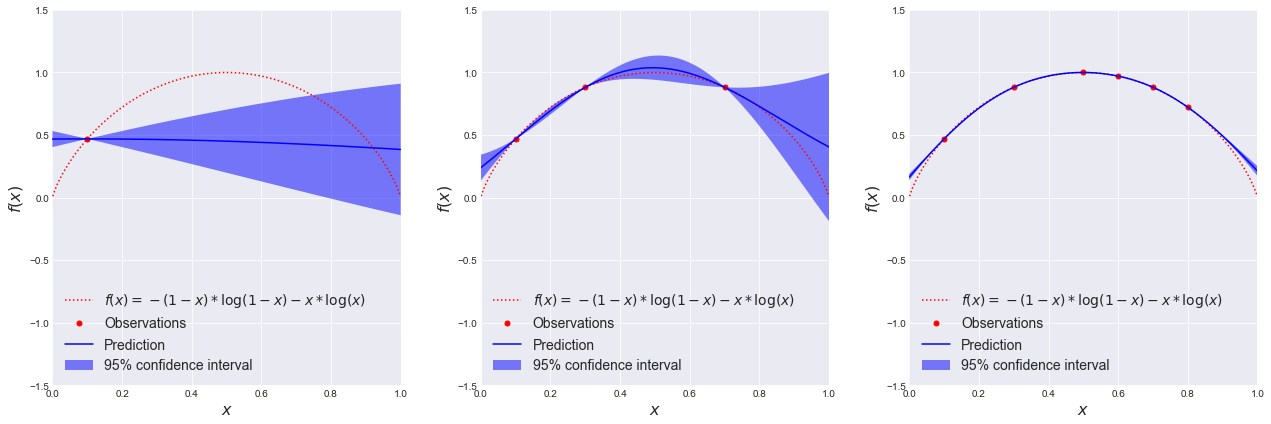

In [7]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)
plt.style.use('seaborn-darkgrid')

def f(x):
    """The function to predict."""
    return -(1-x)*np.log2(1-x)-x*np.log2(x)

fig, ax = plt.subplots(1,3, figsize=(18,6))
xs = [[.1],[.1,.3,.7],[.1, .3, .5, .6, .7, .8]]
for a,xi in zip(ax,xs):
    # ----------------------------------------------------------------------
    #  First the noiseless case
    X = np.atleast_2d(xi).T

    # Observations
    y = f(X).ravel()

    # Mesh the input space for evaluations of the real function, the prediction and
    # its MSE
    x = np.atleast_2d(np.linspace(0, 1, 1000)).T

    # Instantiate a Gaussian Process model
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(x, return_std=True)

    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    a.plot(x, f(x), 'r:', label=r'$f(x) = -(1-x)*\log(1-x)-x*\log(x)$')
    a.plot(X, y, 'r.', markersize=10, label='Observations')
    a.plot(x, y_pred, 'b-', label='Prediction')
    a.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    a.set_xlabel('$x$', fontdict={"fontsize":16})
    a.set_ylabel('$f(x)$', fontdict={"fontsize":16})
    a.set_ylim(-1.5,1.5)
    a.set_xlim(0,1)
    a.legend(loc='lower left', prop={"size":14})
plt.tight_layout()

# Surrogate model
$$f(x) = x*sin(x)$$

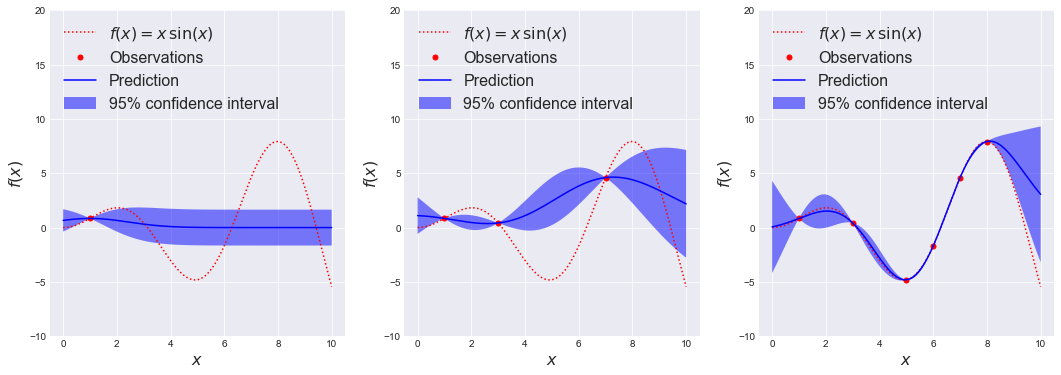

In [9]:
np.random.seed(1)
plt.style.use('seaborn-darkgrid')

def f(x):
    """The function to predict."""
    return x * np.sin(x)
fig, ax = plt.subplots(1,3, figsize=(18,6))
xs = [[1.],[1.,3.,7.],[1., 3., 5., 6., 7., 8.]]
for a,xi in zip(ax,xs):
    # ----------------------------------------------------------------------
    #  First the noiseless case
    X = np.atleast_2d(xi).T

    # Observations
    y = f(X).ravel()

    # Mesh the input space for evaluations of the real function, the prediction and
    # its MSE
    x = np.atleast_2d(np.linspace(0, 10, 1000)).T

    # Instantiate a Gaussian Process model
    kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, y)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(x, return_std=True)

    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    a.plot(x, f(x), 'r:', label=r'$f(x) = x\,\sin(x)$')
    a.plot(X, y, 'r.', markersize=10, label='Observations')
    a.plot(x, y_pred, 'b-', label='Prediction')
    a.fill(np.concatenate([x, x[::-1]]),
             np.concatenate([y_pred - 1.9600 * sigma,
                            (y_pred + 1.9600 * sigma)[::-1]]),
             alpha=.5, fc='b', ec='None', label='95% confidence interval')
    a.set_xlabel('$x$', fontdict={"fontsize":16})
    a.set_ylabel('$f(x)$', fontdict={"fontsize":16})
    a.set_ylim(-10, 20)
    a.legend(loc='upper left', prop={"size":16})

# Acquisition model

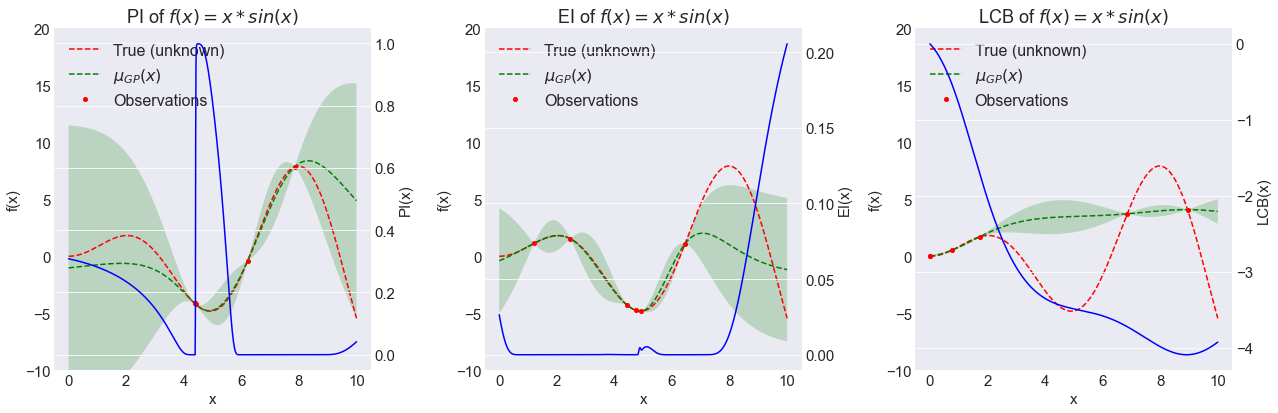

In [12]:
np.random.seed(1234)

def objective(x):
    return x[0]*np.sin(x[0])
plt.rc('font', size=15) 

opt = Optimizer([(0.,10.)], "GP", n_initial_points=3,
                acq_optimizer="sampling")

# Plotting parameters
plot_args = {"objective": objective, "show_legend": False,
             "show_title": False, "show_next_point": False,
             "show_acq_func": True}
initial_points = 3

fig, axs = plt.subplots(1,3, figsize=(18,6))
acquisition = ["PI", "EI", "LCB"]
for ax, acq in zip(axs, acquisition):
    acq_func_kwargs = {"xi": 0.000001, "kappa": 0.001}
    opt = Optimizer([(0.,10.)], "GP", n_initial_points=initial_points,
                    acq_func=acq, acq_optimizer="sampling",
                    acq_func_kwargs=acq_func_kwargs)
    opt.run(objective, n_iter=6)
    _ = plot_gaussian_process(opt.get_result(), ax=ax, **plot_args)
    ax.set_ylim(-10,20)
    ax.legend(loc='upper left', prop={"size":16})

axs[0].set_title("PI of $f(x)=x*sin(x)$")
axs[1].set_title("EI of $f(x)=x*sin(x)$")
axs[2].set_title("LCB of $f(x)=x*sin(x)$")
plt.tight_layout()

# How high can sigma be to uphold
$$\int_{-\infty}^l f(x) = \int_u^\infty f(x) = 0$$

$$\sum_{-\infty}^l P(x) = \sum_u^\infty P(x) = 0$$

In [8]:
for sigma in np.linspace(0.0001,10, 100_000):
    s = sum(st.norm.pdf(np.linspace(100,101,100), 50,sigma))
    if s > 0:
        print(sigma, s)
        break

1.2962 5e-324


# Ideal choice for number of sample

Text(0, 0.5, 'Error between estimate and actual')

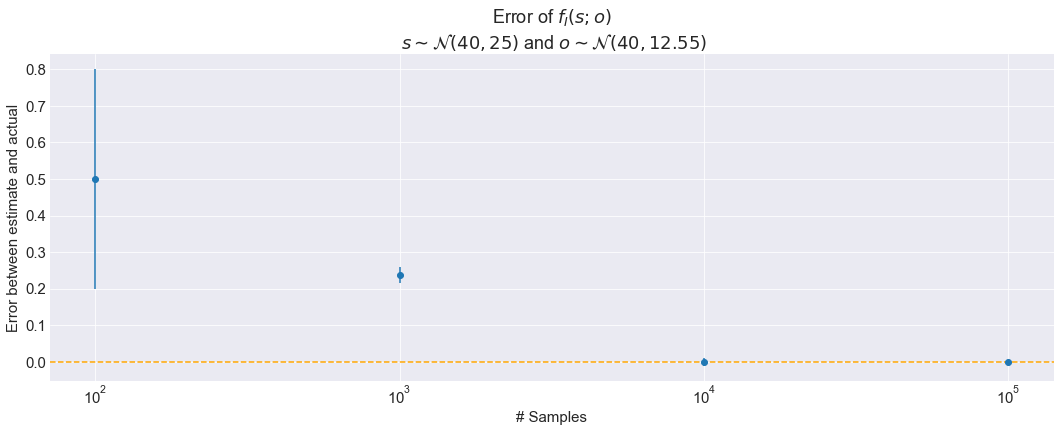

In [13]:
def sampling(p,s):
    I = lambda std: ((np.log(sum(np.square(std))) - np.log(sum(np.square(std[1:])))))/2
    a = st.norm(40,25).rvs(s)
    b = st.norm(40,0.1).rvs(s)
    o = (a+b)/2
    return mutual_info_regression(a.reshape(-1,1),o, discrete_features=False)[0], I([25,0.1])

parameters = np.linspace(0.1,25, 100)
sample = np.arange(100,100_000, 10_000)

res = []
for s in [100,1000,10_000,100_000]:
    actual = []
    estimate = []
    for p in parameters:
        t1,t2 = sampling(p,s)
        actual.append(t1)
        estimate.append(t2)
    res.append((np.asarray(actual)-np.array(estimate)))
    
err = np.array([np.std(r) for r in res])
mean = [(r**2).mean() for r in res]
x = [100,1000,10_000,100_000]
fig,ax = plt.subplots(1,1,figsize=(18,6))
ax.errorbar(x,mean,yerr=err, fmt="o")
ax.set_xscale("log")
ax.axhline(0, linestyle="--", color="orange")

ax.set_title("Error of $f_{I}(s;o)$\n $s \sim \mathcal{N}(40,25)$ and $o \sim \mathcal{N}(40,12.55)$")
ax.set_xlabel("# Samples")
ax.set_ylabel("Error between estimate and actual")

# Altering between random, entropy or pymc3

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [p-0, p-1, p-2, p-3, p-4, p-5, p-6, p-7, p-8, p-9, p-10, p-11, p-12, p-13, p-14, p-15, p-16, p-17, p-18, p-19, p-20, p-21, p-22, p-23, p-24, p-25, p-26, p-27, p-28, p-29, p-30, p-31, p-32, p-33, p-34, p-35, p-36, p-37, p-38, p-39, p-40, p-41, p-42, p-43, p-44, p-45, p-46, p-47, p-48, p-49, p-50, p-51, p-52, p-53, p-54, p-55, p-56, p-57, p-58, p-59, p-60, p-61, p-62, p-63, p-64, p-65, p-66, p-67, p-68, p-69, p-70, p-71, p-72, p-73, p-74, p-75, p-76, p-77, p-78, p-79, p-80, p-81, p-82, p-83, p-84, p-85, p-86, p-87, p-88, p-89, p-90, p-91, p-92, p-93, p-94, p-95, p-96, p-97, p-98, p-99]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 1626 seconds.


Text(0, 0.5, '$H(\\mathbb{B}(p))$')

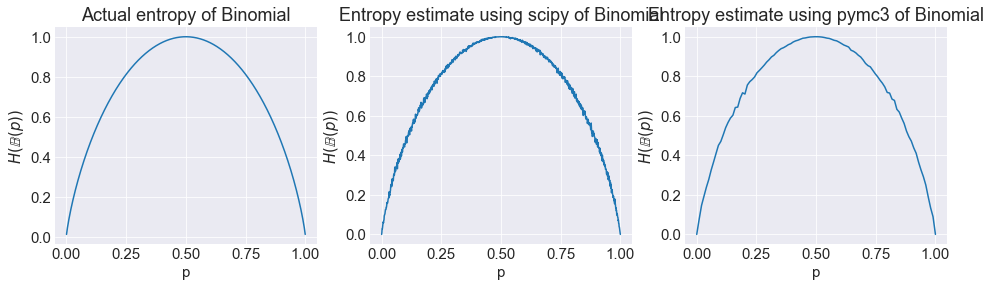

In [14]:
def entropy(t):
    s, counts = np.unique(t, return_counts=True)
    counts = counts/len(t)
    return st.entropy(counts, base=2)

x = np.linspace(0,1,1000)
real = lambda x: -(1-x)*np.log2(1-x)-x*np.log2(x)

yr = [real(xi) for xi in x]
ys = [entropy(st.bernoulli(xi).rvs(10_000)) for xi in x]
x2 = np.linspace(0,1,100)
with pm.Model() as model:
    for i, p in enumerate(x2):  
        bi = pm.Bernoulli(f"p-{i}", p)
    trace = pm.sample(10_000, return_inferencedata=False)
    yp = [entropy(trace["p-"+str(i)]) for i in range(100)]

fig,ax = plt.subplots(1,3, figsize=(16,4))
ax[0].plot(x,yr)
ax[0].set_title("Actual entropy of Binomial")
ax[0].set_xlabel("p")
ax[0].set_ylabel("$H(\mathbb{B}(p))$")


ax[1].plot(x,ys)
ax[1].set_title("Entropy estimate using scipy of Binomial")
ax[1].set_xlabel("p")
ax[1].set_ylabel("$H(\mathbb{B}(p))$")

ax[2].plot(x2,yp)
ax[2].set_title("Entropy estimate using pymc3 of Binomial")
ax[2].set_xlabel("p")
ax[2].set_ylabel("$H(\mathbb{B}(p))$")

# Splitting domains

Text(25, 0.5, 'Binomial')

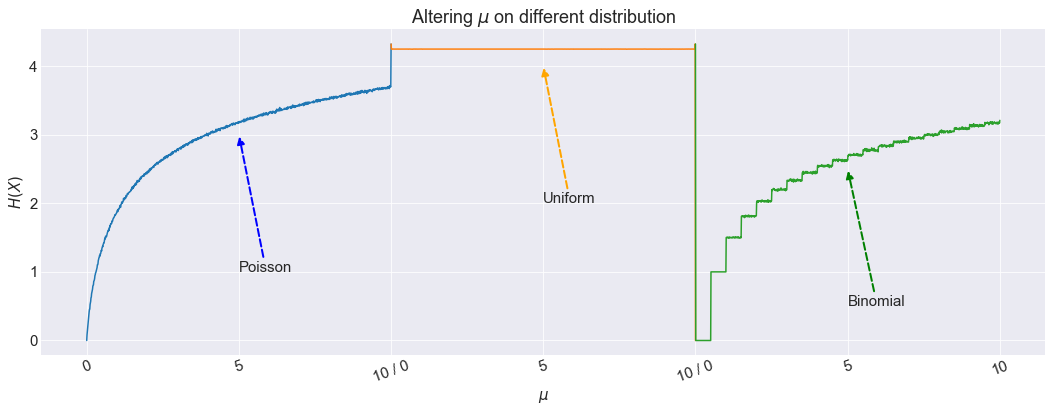

In [15]:
def count_entropy(i, mu, samples):
    if i == 0:
        t = st.poisson(mu).rvs(samples)
    elif i == 1:
        t = st.randint(mu-10, mu+10).rvs(samples)
    else:
        t = st.binom(int(mu*2), 0.5).rvs(samples)
    s, counts = np.unique(t, return_counts=True)
    counts = counts/len(t)
    return st.entropy(counts, base=2)
ids = [0,1,2]
mus = np.linspace(0,10,1000)

x = []
y = []
z = []
for i in ids:
    for mu in mus:
        x.append(i)
        y.append(mu)
        z.append(count_entropy(i,mu,10_000))
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(111)
plt.style.use('seaborn-darkgrid')
#ax.plot(np.linspace(0,30,3000),z)
ax.plot(np.linspace(0,10,1001),z[:1001])
ax.plot(np.linspace(10,20,1001),z[1000:2001])
ax.plot(np.linspace(20,30,1001),z[1999:])
ax.set_xticks(np.arange(0,31,step=5))
ax.set_xticklabels([0,5,"10 / 0",5,"10 / 0",5,10], rotation=20)
ax.set_ylabel("$H(X)$")
ax.set_title("Altering $\mu$ on different distribution")
ax.set_xlabel("$\mu$")


ax.annotate('Poisson', xy=(5, 3),
             xycoords='data',
             xytext=(5, 1),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='blue',
                             lw=2,
                             ls='--')
           )

ax.annotate('Uniform', xy=(15, 4),
             xycoords='data',
             xytext=(15, 2),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='orange',
                             lw=2,
                             ls='--')
           )

ax.annotate('Binomial', xy=(25, 2.5),
             xycoords='data',
             xytext=(25, 0.5),
             textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='green',
                             lw=2,
                             ls='--')
           )

# Evaluation
The figures here are only showed from stored data, the actual programs used to generate the leakage are within the file called `Evaluation.ipynb`

## Average age (mean)

In [42]:
result = pd.read_csv("Evaluations/mean_normal_result.csv")
result.iloc[result["score"].idxmax()]

Unnamed: 0    11.000000
score          3.897838
mu            23.296258
sigma          0.100000
Name: 11, dtype: float64

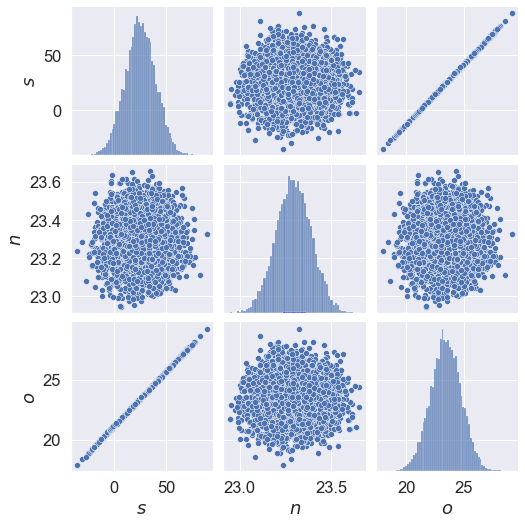

In [52]:
s = st.norm(25,15).rvs(10_000)
n = [st.norm(23.296258, 0.1).rvs(10_000) for i in range(10)]
o = (s+sum(n))/11

#Plot
sns.set(font_scale = 1.5)
dist = {"$s$": s, "$n$": n[0], "$o$": o}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=False, discrete=False, color="blue", stat='density')

## Average age (median)

In [58]:
result = pd.read_csv("Evaluations/median_age_normal.csv")
result.iloc[result["score"].idxmax()]

Unnamed: 0     54.000000
score           1.092501
mu             32.342184
sigma         121.346747
Name: 54, dtype: float64

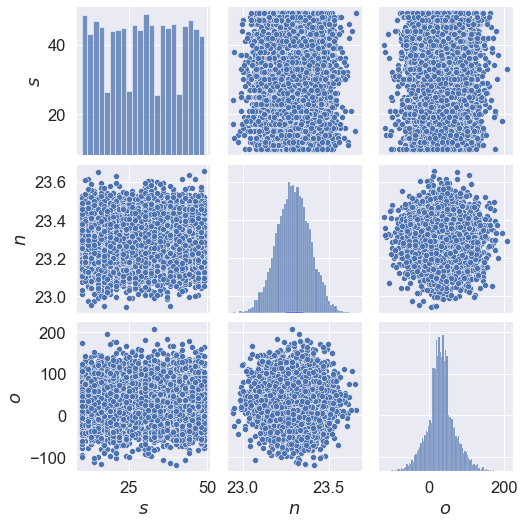

In [62]:
s = st.randint(10,50).rvs(10_000)
a = [st.randint(10,50).rvs(10_000) if not i else st.norm(32.342183, 121.346747).rvs(10_000) for i in range(11)]
o = np.median(a,axis=0)

#Plot
sns.set(font_scale = 1.5)
dist = {"$s$": s, "$n$": n[0], "$o$": o}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=False, discrete=False, color="blue", stat='density')

## Average age all dist

In [65]:
result_norm = pd.read_csv("Evaluations/mean_normal_result.csv")
result_uni = pd.read_csv("Evaluations/mean_uniform_result.csv")
result_half = pd.read_csv("Evaluations/mean_half_normal_result.csv")

print("Normal")
print(result_norm.iloc[result_norm["score"].idxmax()])
print("="*20)
print("Uniform")
print(result_uni.iloc[result_uni["score"].idxmax()])
print("="*20)
print("Half Normal")
print(result_half.iloc[result_half["score"].idxmax()])

Normal
Unnamed: 0    11.000000
score          3.897838
mu            23.296258
sigma          0.100000
Name: 11, dtype: float64
Uniform
Unnamed: 0    55.000000
score          2.746746
lower         29.575161
scale          1.095464
Name: 55, dtype: float64
Half Normal
Unnamed: 0    35.000000
score          4.423555
mu            30.413257
sigma          0.100000
Name: 35, dtype: float64


## Average age with Differential Privacy

In [66]:
result_norm = pd.read_csv("Evaluations/DP_average_age_normal.csv")
result_uni = pd.read_csv("Evaluations/DP_average_age_uniform.csv")
result_half = pd.read_csv("Evaluations/DP_average_age_halfNormal.csv")

print("Normal")
print(result_norm.iloc[result_norm["MI"].idxmax()])
print("="*20)
print("Uniform")
print(result_uni.iloc[result_uni["MI"].idxmax()])
print("="*20)
print("Half Normal")
print(result_half.iloc[result_half["MI"].idxmax()])

Normal
Unnamed: 0    42.000000
MI             0.011263
mu            32.166473
sigma         87.418787
Name: 42, dtype: float64
Uniform
Unnamed: 0     2.000000
MI             0.014583
lower         10.882458
spread        18.477643
Name: 2, dtype: float64
Half Normal
Unnamed: 0    31.000000
MI             0.011709
mu            19.534224
sigma         14.654937
Name: 31, dtype: float64


### Average age dp where:
```q(a : float, b: float) -> float```

In [69]:
comb = np.array([np.arange(0,3) for _ in range(2)])
comb = np.array(np.meshgrid(*comb)).T.reshape(-1,2)
names = ["normal", "unifom", "halfNormal"]
getName = lambda i: ("lower","spread") if i == 1  else ("mu", "sigma")
for i, x in enumerate(comb):
    ai,bi = x
    al,au = getName(ai)
    bl,bu = getName(bi)
    result = pd.read_csv("Evaluations/DP_single_param-"+names[ai]+"-"+names[bi]+".csv")
    print(result.iloc[result["MI"].idxmax()])
    print("="*10+f" a<-{names[ai]} vs. b<-{names[bi]} "+"="*10)

Unnamed: 0     26.000000
MI              0.015246
mu-a           37.929018
sigma-a        66.542370
mu-b           28.783089
sigma-b       128.558539
Name: 26, dtype: float64
========== a<-normal vs. b<-normal ==========
Unnamed: 0    29.000000
MI             0.013438
mu-a          10.690796
sigma-a       31.065288
lower-b       25.105430
spread-b      13.669985
Name: 29, dtype: float64
========== a<-normal vs. b<-unifom ==========
Unnamed: 0    13.000000
MI             0.010747
mu-a          23.355911
sigma-a       91.435370
mu-b          22.286312
sigma-b       12.231587
Name: 13, dtype: float64
========== a<-normal vs. b<-halfNormal ==========
Unnamed: 0      7.000000
MI              0.013537
lower-a        45.536808
spread-a        1.892241
mu-b           26.990836
sigma-b       126.918954
Name: 7, dtype: float64
========== a<-unifom vs. b<-normal ==========
Unnamed: 0    28.000000
MI             0.010428
lower-a       16.781264
spread-a      29.256033
lower-b       16.313495
sprea

## Convergence
### Mutual Information

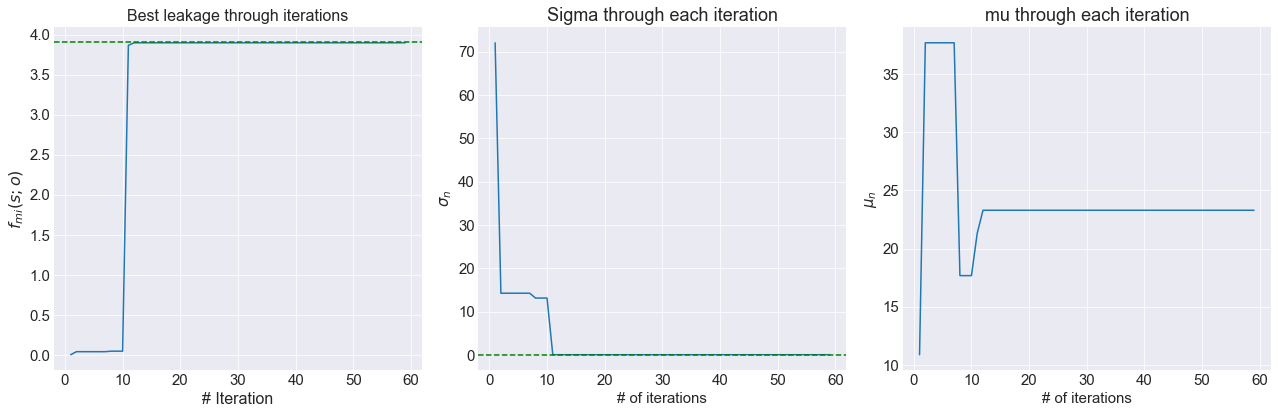

In [33]:
result = pd.read_csv("Evaluations/mean_normal_result.csv")
score = result["score"]
def fmi(X):
    res = (np.log(15*15+9*X**2)-np.log(9*X**2))/2
    return res

x = np.linspace(0.1,1/12*(40)**2, 1000)
y = [fmi(xi) for xi in x]

plt.style.use('seaborn-darkgrid')

siz = len(score)
best = np.array([max(score[:i]) for i in range(1,siz)])

best_std = np.array([result["sigma"][np.argmax(score[:i])] for i in range(1,siz)])
best_mu = np.array([result["mu"][np.argmax(score[:i])] for i in range(1,siz)])

x = np.arange(1,siz)
fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].plot(x, best, "-")
ax[0].axhline(fmi(0.1), linestyle="--", color="green")
ax[0].set_xlabel("# Iteration", fontdict={"fontsize": 16})
ax[0].set_ylabel("$f_{mi}(s;o)$", fontdict={"fontsize": 16})
ax[0].set_title("Best leakage through iterations", fontdict={"fontsize": 16})

ax[1].plot(x, best_std)
ax[1].set_xlabel("# of iterations")
ax[1].set_ylabel("$\sigma_n$")
ax[1].axhline(0.1, linestyle="--", color="green")
ax[1].set_title("Sigma through each iteration")

ax[2].plot(x, best_mu)
ax[2].set_xlabel("# of iterations")
ax[2].set_ylabel("$\mu_n$")
ax[2].set_title("mu through each iteration")
plt.tight_layout()

### Entropy

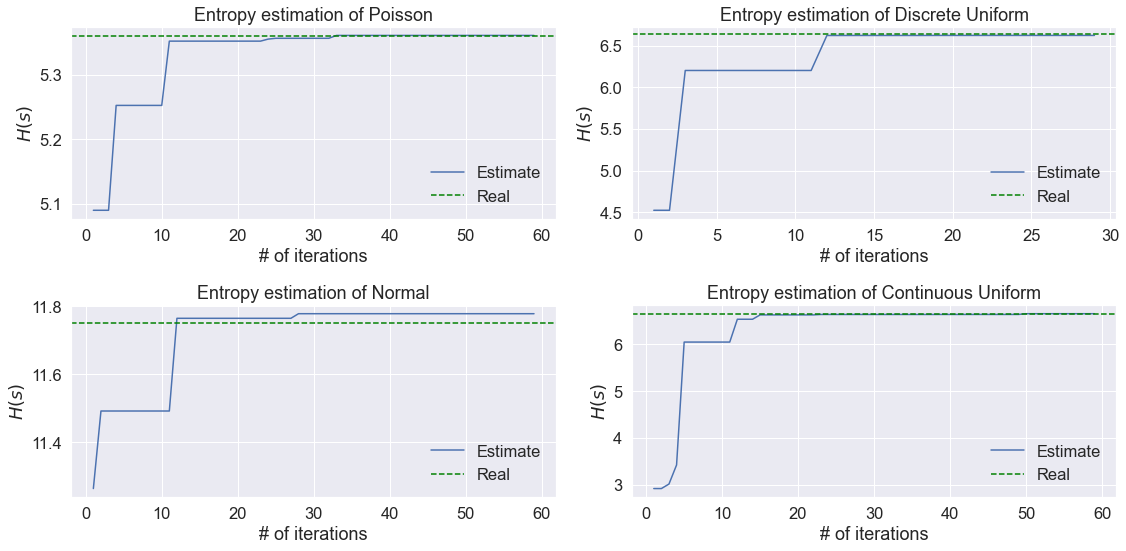

In [71]:
d = pd.read_csv("Evaluations/EntropyConvergence.csv")
x_pois = np.arange(1,len(d["entropy Poisson"]))
x_uni = np.arange(1,len(d["entropy Discrete Uniform"][:30]))
# continuous
x_normal = np.arange(1,len(d["entropy Normal"]))
x_uni_cont = np.arange(1,len(d["entropy Continuous Uniform"]))

y_pois = -np.array([min(d["entropy Poisson"][:i]) for i in range(1,len(x_pois)+1)])
y_uni = -np.array([min(d["entropy Discrete Uniform"][:i]) for i in range(1,len(x_uni)+1)])
#continuous
y_normal = np.log2(np.exp(-np.array([min(d["entropy Normal"][:i]) for i in range(1,len(x_normal)+1)])))
y_uni_cont = np.log2(np.exp(-np.array([min(d["entropy Continuous Uniform"][:i]) for i in range(1,len(x_uni_cont)+1)])))


fig, ax = plt.subplots(2,2,figsize=(16,8))

ax[0,0].plot(x_pois, y_pois, label="Estimate")
poiss_entropy = np.log2(np.exp(st.poisson(99,1).entropy()))
ax[0,0].axhline(poiss_entropy, linestyle="--", color="green", label="Real")
ax[0,0].set_title("Entropy estimation of Poisson")

ax[0,1].plot(x_uni, y_uni, label="Estimate")
ax[0,1].axhline(np.log2(100), linestyle="--", color="green", label="Real")
ax[0,1].set_title("Entropy estimation of Discrete Uniform")

ax[1,0].plot(x_normal, y_normal, label="Estimate")
normal_entrop = np.log2(np.exp(st.norm(0, 1/12*np.square(100)).entropy()))
ax[1,0].axhline(normal_entrop, linestyle="--", color="green", label="Real")
ax[1,0].set_title("Entropy estimation of Normal")


ax[1,1].plot(x_uni_cont, y_uni_cont, label="Estimate")
ax[1,1].axhline(np.log2(100), linestyle="--", color="green", label="Real")
ax[1,1].set_title("Entropy estimation of Continuous Uniform")


for a in ax:
    for axs in a:
        axs.set_xlabel("# of iterations")
        axs.set_ylabel("$H(s)$")
        axs.legend()
plt.tight_layout()

### F-Bleau Bayes Risk

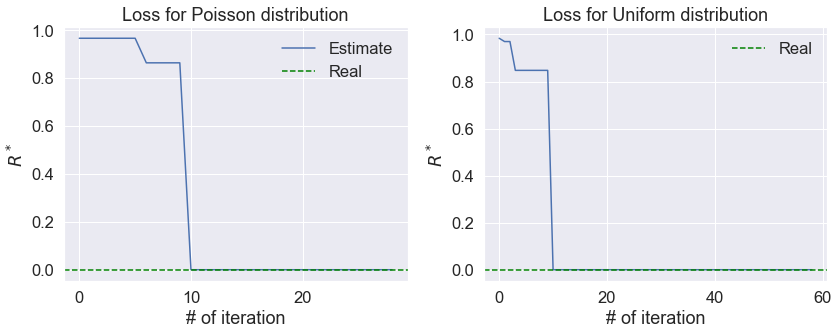

In [72]:
res = pd.read_csv("Evaluations/BayesRiskConvergence.csv")
poisson_loss = [min(res["BayesRisk Poisson Distribution"][:i]) for i in range(1,30)]
uniform_loss = [min(res["BayesRisk Discrete Uniform Distribution"][:i]) for i in range(1,60)]



fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].plot(np.arange(len(poisson_loss)), poisson_loss, "-", label="Estimate")
ax[0].set_title("Loss for Poisson distribution")
ax


ax[1].plot(np.arange(len(uniform_loss)), uniform_loss, "-")
ax[1].set_title("Loss for Uniform distribution")


for a in ax:
    a.set_ylabel("$R^*$")
    a.set_xlabel("# of iteration")
    a.axhline(0,linestyle="--", color="green", label="Real")
    a.legend()
plt.tight_layout()

## Metric Comparison (Bayes risk vs mutual information)

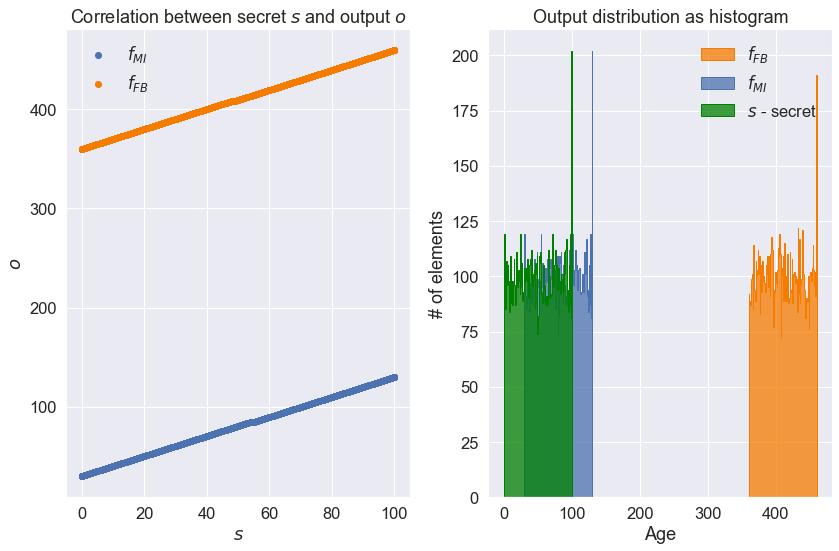

In [98]:
trace_MI = pd.read_csv("Evaluations/MI_summation_uniform_samples.csv")
trace_FB = pd.read_csv("Evaluations/BR_summation_uniform_samples.csv")

fig, ax = plt.subplots(1,2,figsize=(12,8))
ax[0].scatter(trace_MI["Alice_a"], trace_MI["out"], label=r"$f_{MI}$")
ax[0].scatter(trace_FB["Alice_a"],trace_FB["out"], label="$f_{FB}$", color="#f57c00")
ax[0].set_title("Correlation between secret $s$ and output $o$")
ax[0].set_ylabel("$o$")
ax[0].set_xlabel("$s$")

x = np.arange(100)
s,n = st.randint(0,100).pmf(x), st.randint(10,11).pmf(x) 
sns.histplot(trace_FB["out"], ax=ax[1], element="step", bins=100, label="$f_{FB}$", color="#f57c00")
sns.histplot(trace_MI["out"], ax=ax[1], element="step", bins=100, label="$f_{MI}$")
sns.histplot(trace_MI["Alice_a"], ax=ax[1], element="step", bins=100, label="$s$ - secret", color="green")
ax[1].set_title("Output distribution as histogram")
ax[1].set_ylabel("# of elements")
ax[1].set_xlabel("Age")

for axs in ax:
    axs.legend()
plt.tight_layout()

## Consistency

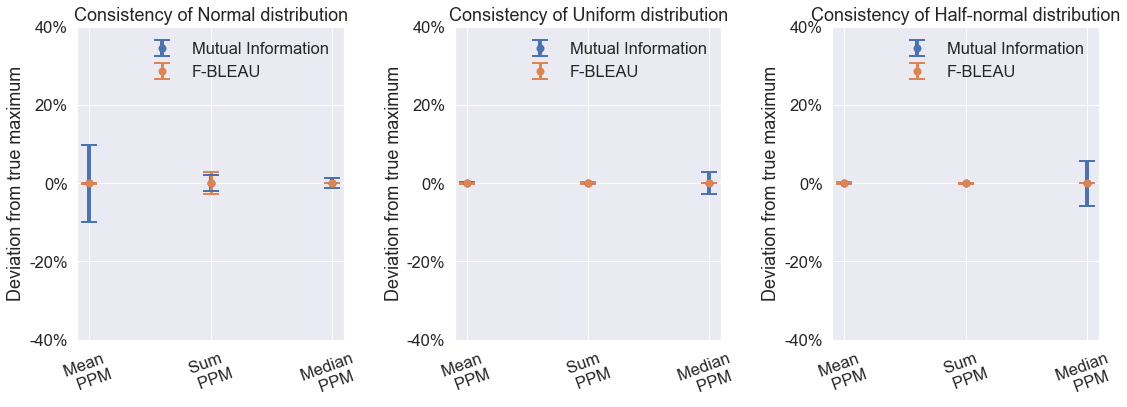

In [94]:
normals = pd.read_csv("Evaluations/normals_consistency.csv").to_numpy().T[1:]
uniforms = pd.read_csv("Evaluations/uniforms_consistency.csv").to_numpy().T[1:]
half_normals = pd.read_csv("Evaluations/half_normals_consistency.csv").to_numpy().T[1:]
def error(ax, n):
    yerr = np.sqrt((n.reshape(6,10) - np.median(n, axis=1).reshape(-1,1))**2).mean(axis=1)
    x = np.arange(3)
    best = np.min(n, axis=1).flatten()
    ax.errorbar(x, [0]*len(x), yerr=yerr[:3]/best[:3], 
                fmt="o", 
                label="Mutual Information",
                capsize=8, 
                elinewidth=4,
                markeredgewidth=2)
    ax.errorbar(x, [0]*len(x), yerr=yerr[3:]/1, fmt="o", 
                label="F-BLEAU",
                capsize=8, 
                elinewidth=3,
                markeredgewidth=2)
    ax.set_xticks(x)
    ax.set_xticklabels(["Mean \n PPM", "Sum \n PPM", "Median \n PPM"], rotation=20)
    ax.set_ylim(-.4,.4)
    ax.set_yticks([-.4,-.2, 0, .2, .4])
    ax.set_yticklabels(["-40%","-20%", "0%","20%", "40%"])
    ax.set_ylabel("Deviation from true maximum")

fig,ax = plt.subplots(1,3, figsize=(16,6))
error(ax[0],normals)
error(ax[1], uniforms)
error(ax[2], half_normals)

ax[0].set_title("Consistency of Normal distribution")
ax[1].set_title("Consistency of Uniform distribution")
ax[2].set_title("Consistency of Half-normal distribution")
for axs in ax:
    axs.legend()

plt.tight_layout()

## Average Age K-Anonymity

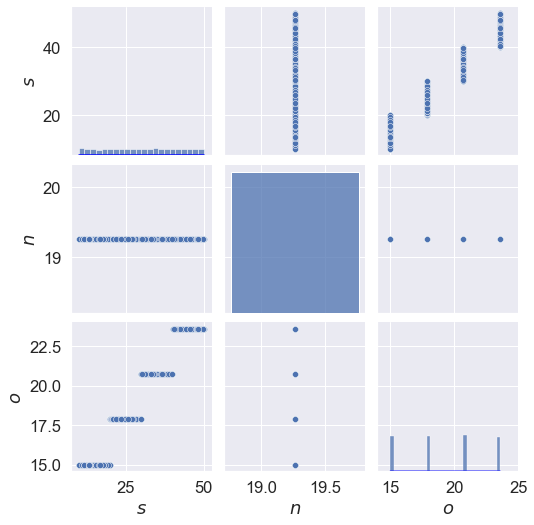

In [99]:
trace = pd.read_csv("Evaluations/KAnon-distSamples.csv")
sns.set(font_scale = 1.5)
dist = {"$s$": trace["Alice_age"], "$n$": trace["Rest_age"][0], "$o$": trace["out"]}
d = data=pd.DataFrame(dist)

g = sns.pairplot(d)
g.map_diag(sns.histplot, kde=True, discrete=True, color="blue", stat='density')

In [103]:
names = ["Poisson", "Uniform"]
for i in range(2):
    print("="*10+f" {names[i]} "+"="*10)    
    result = pd.read_csv("Evaluations/KAnon-"+names[i] + ".csv")
    print(result.iloc[result["MI"].idxmax()])

========== Poisson ==========
Unnamed: 0    32.000000
MI             1.386210
lambda        19.089223
loc            0.100000
Name: 32, dtype: float64
========== Uniform ==========
Unnamed: 0    22.000000
MI             1.386230
lower         15.331907
spread         1.095813
Name: 22, dtype: float64
